In [16]:
import os
import sys
import json
import requests
import numpy as np
import pandas as pd
import pytz
import mpld3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from urllib.request import Request, urlopen
from requests.models import PreparedRequest
from pydantic import BaseModel, Field
from enum import Enum
from typing import Optional, Dict, Any, List, Tuple
from pydantic_ai import Agent
import plotly.express as px
from rasterio.io import MemoryFile
import plotly.io as pio

# local module
sys.path.append('/Users/williamharrigan/Desktop/hackathon/')
from codes import *

output_dir = '/Users/williamharrigan/Desktop/hackathon/'



In [2]:
prompt_process_query = """You are an AI assistant for the Hawai'i Climate Data Portal. 
You are responsible for answering the user query based on the results you get back from the tools.

When a user asks a query, carefully analyze the query and determine the best way to respond to the following questions:
1. What are the specific information the user is asking for?
2. What tools do you need to use to get the information?
3. What is the best way to format the response?

Plan your response step by step using the available tools and respond with the final answer only.

Output Format:
Only respond with the final answer. Do not lead the user to more conversation.
"""

In [3]:
prompt_process_agent = Agent(  
    # "groq:deepseek-r1-distill-llama-70b",
    "gemini-2.5-pro-exp-03-25",
    result_type=str,    
    system_prompt=prompt_process_query,
    model_settings={'temperature': 0.0}    
)

# You will be given a token to access the HCDP API. Add that token here.
hcdp_api_token = os.environ["hcdp_api_token"]
# Please input your email address. This will be used for user logging or distributing data packages
email = "akib_farts@stinky.edu"

api_base_url = "https://api.hcdp.ikewai.org"
# Setup header for API requests
header = {
  "Authorization": f"Bearer {hcdp_api_token}"
}

In [14]:
class DataType(str, Enum):
    TEMPERATURE = "temperature"
    RAINFALL = "rainfall"
    RELATIVE_HUMIDITY = "relative_humidity"
    NDVI_MODIS = "ndvi_modis"
    IGNITION_PROBABILITY = "ignition_probability"

class Aggregation(str, Enum):
    MIN = "min"
    MAX = "max"
    MEAN = "mean"

class Production(str, Enum):
    '''
    Production can be "new" or "legacy". Legacy rainfall maps are available from 1920-2012, whereas new rainfall maps are available from 1990-present
    '''
    NEW = "new"
    LEGACY = "legacy"

class Period(str, Enum):
    '''
    This is the resolution of the datapoints. NDVI_MODIS only has a DAY resolution. If user asks for year or month for NDVI, return DAY
    '''
    DAY = "day"
    MONTH = "month"
    YEAR = "year"

class Extent(str, Enum):
    '''
    HAWAII = Big Island, Hawai'i
    KAUAI = Kauai island, Hawai'i
    HONOLULU = O'ahu island, Hawai'i
    MLM = Moloka'i and Lanai islands, Maui island, 
    STATEWIDE = any time latitude and longitude coordinates are input, extent = statewide    
    '''
    STATEWIDE = "statewide"  # Data for the whole state
    HAWAII = "bi"            # Hawaii county
    KAUAI = "ka"             # Kauai county
    MLM = "mn"              # Maui, Molokai, Lanai county
    HONOLULU = "oa"          # Honolulu county

class ClimateDataParams(BaseModel):
    datatype: DataType
    period: Period
    start: str
    end: str
    extent: Extent
    lat: Optional[float] = None
    lng: Optional[float] = None
    # Optional fields that differ between temperature and rainfall
    aggregation: Optional[Aggregation] = None
    production: Optional[Production] = None


In [5]:
## Time Series Extraction


class ClimateAPI:     
    def __init__(self, api_base_url: str, header: Dict[str, str]):         
        self.api_base_url = api_base_url         
        self.header = header         
        self.raster_timeseries_ep = "/raster/timeseries"              

    def get_timeseries_data(self, params: ClimateDataParams) -> pd.DataFrame:         
        """Get timeseries data from the API based on provided parameters"""         
        url = f"{self.api_base_url}{self.raster_timeseries_ep}"                  
        params_dict = params.model_dump()
        
        # Remove None values from params
        params_dict = {k: v for k, v in params_dict.items() if v is not None}
                  
        res = requests.get(url, params_dict, headers=self.header)         
        res.raise_for_status()         
        print(f"Constructed API request URL: {res.url}")                  
        data = res.json()         
        df_data = list(data.items())                  
        
        # Determine value column name based on datatype
        if params.datatype == DataType.TEMPERATURE:
            value_col = f"{params.aggregation.value.capitalize()} {params.datatype.value.capitalize()} (°C)"
        else:  # For rainfall
            value_col = f"{params.datatype.value.capitalize()} (mm)"
                  
        df = pd.DataFrame(df_data, columns=["Date", value_col])         
        df = df.sort_values(by="Date")                  
        return df   

    def plot_timeseries(self, df: pd.DataFrame, params: ClimateDataParams) -> None:
        """Line plot of timeseries data using Plotly. This is specifically for plotting a variable over time. Always output HTML unless specifically told not to."""
        value_col = df.columns[1]  # Second column contains the values
        
        # Create appropriate title based on params
        if params.datatype == DataType.TEMPERATURE:
            title = f"Summary of {params.aggregation.value} {params.datatype.value} from {params.start} to {params.end}"
        else:
            title = f"Summary of {params.datatype.value} from {params.start} to {params.end}"
            
        if params.lat is not None and params.lng is not None:
            title += f" for location Latitude: {params.lat}, Longitude: {params.lng}"
            
        fig = px.line(df, title=title, x="Date", y=value_col)
        fig.write_html(f"{output_dir}/ndvis.html")
        return fig

@prompt_process_agent.tool_plain  
def get_temperature_timeseries(     
    aggregation: Aggregation,     
    period: Period,     
    lat: float,     
    lng: float,     
    start_date: Optional[str] = None,      
    end_date: Optional[str] = None,
    extent: Optional[Extent] = Extent.STATEWIDE
) -> Dict[str, Any]:     
    """Return temperature timeseries data for the specified location, period and aggregation"""     
    api = ClimateAPI(api_base_url=api_base_url, header=header)     
    print("API initialized:", api)          

    today = datetime.now(pytz.timezone("US/Hawaii"))     
    yesterday = today - timedelta(days=1)     
    previous_year = today - relativedelta(years=1)          

    start_str = start_date if start_date else previous_year.strftime("%Y-%m-%d")     
    end_str = end_date if end_date else yesterday.strftime("%Y-%m-%d")          

    # Create params for temperature (requires aggregation)
    params = ClimateDataParams(         
        datatype=DataType.TEMPERATURE,         
        aggregation=aggregation,         
        period=period,         
        start=start_str,         
        end=end_str,         
        # extent=extent,     
        extent="statewide",   
        lat=lat,         
        lng=lng     
    )          

    print("Query parameters:", params)          

    df = api.get_timeseries_data(params)          

    # Return structured result with data preview + summary     
    result = {         
        "data_preview": df.head(5).to_dict(orient="records") + df.tail(5).to_dict(orient="records"),
        "summary": {             
            "mean": df.iloc[:, 1].mean(),             
            "min": df.iloc[:, 1].min(),             
            "max": df.iloc[:, 1].max(),             
            "location": {"lat": lat, "lng": lng},             
            "period": f"{start_str} to {end_str}"         
        }     
    }

    # Plot the time series if data exists and has a "Date" column
    if not df.empty and "Date" in df.columns:
        api.plot_timeseries(df, params)
        print("Time series plot has been generated.")
    else:
        print("No time series data available for plotting.")
     
    return result  

@prompt_process_agent.tool_plain  
def get_rainfall_timeseries(     
    period: Period,     
    lat: float,     
    lng: float,     
    start_date: Optional[str] = None,      
    end_date: Optional[str] = None,
    production: Production = Production.NEW,
    extent: Optional[Extent] = Extent.STATEWIDE
) -> Dict[str, Any]:     
    """Return the max, mean and min of the rainfall data. The period for rainfall can only be monthly or daily. Keep it concise."""     
    api = ClimateAPI(api_base_url=api_base_url, header=header)     
    print("API initialized:", api)          

    today = datetime.now(pytz.timezone("US/Hawaii"))     
    yesterday = today - timedelta(days=1)     
    previous_year = today - relativedelta(years=1)          

    start_str = start_date if start_date else previous_year.strftime("%Y-%m-%d")     
    end_str = end_date if end_date else yesterday.strftime("%Y-%m-%d")          

    # Create params for rainfall (requires production instead of aggregation)
    params = ClimateDataParams(         
        datatype=DataType.RAINFALL,         
        production="new",         
        period=period, 
        start = start_str,
        end = end_str,
        extent="statewide",    
        lat=lat,         
        lng=lng     
    )      
    
    print("Query parameters:", params)          

    df = api.get_timeseries_data(params)          

    # Return structured result with data preview + summary     
    result = {         
        "data_preview": df.head(5).to_dict(orient="records") + df.tail(5).to_dict(orient="records"),
        "summary": {             
            "mean": df.iloc[:, 1].mean(),             
            "min": df.iloc[:, 1].min(),             
            "max": df.iloc[:, 1].max(),             
            "location": {"lat": lat, "lng": lng},             
            "period": f"{start_str} to {end_str}"         
        }     
    }

    # Plot the time series if data exists and has a "Date" column
    if not df.empty and "Date" in df.columns:
        api.plot_timeseries(df, params)
        print("Time series plot has been generated.")
    else:
        print("No time series data available for plotting.")
     
    return result

@prompt_process_agent.tool_plain  
def get_relative_humidity_timeseries(     
    period: str,     
    lat: float,     
    lng: float,     
    start_date: Optional[str] = None,      
    end_date: Optional[str] = None,
    # production: Production = Production.NEW,
    extent: Optional[Extent] = Extent.STATEWIDE
) -> Dict[str, Any]:     
    """Return the max, mean and min relative humidity for the queried location. Keep it concise."""     
    api = ClimateAPI(api_base_url=api_base_url, header=header)     
    print("API initialized:", api)          

    today = datetime.now(pytz.timezone("US/Hawaii"))     
    yesterday = today - timedelta(days=1)     
    previous_year = today - relativedelta(years=1)          

    start_str = start_date if start_date else previous_year.strftime("%Y-%m-%d")     
    end_str = end_date if end_date else yesterday.strftime("%Y-%m-%d")          

    # Create params for rainfall (requires production instead of aggregation)
    params = ClimateDataParams(         
        datatype=DataType.RELATIVE_HUMIDITY,         
        # production="new",         
        period="day", 
        start = start_str,
        end = end_str,
        extent="statewide",    
        lat=lat,         
        lng=lng     
    )      
    
    print("Query parameters:", params)          

    df = api.get_timeseries_data(params)          

    # Return structured result with data preview + summary     
    result = {         
        "data_preview": df.head(5).to_dict(orient="records") + df.tail(5).to_dict(orient="records"),
        "summary": {             
            "mean": df.iloc[:, 1].mean(),             
            "min": df.iloc[:, 1].min(),             
            "max": df.iloc[:, 1].max(),             
            "location": {"lat": lat, "lng": lng},             
            "period": f"{start_str} to {end_str}"         
        }     
    }

    # Plot the time series if data exists and has a "Date" column
    if not df.empty and "Date" in df.columns:
        api.plot_timeseries(df, params)
        print("Time series plot has been generated.")
    else:
        print("No time series data available for plotting.")
     
    return result

@prompt_process_agent.tool_plain  
def get_vegetation_data_timeseries(     
    period: str,     
    lat: float,     
    lng: float,     
    start_date: Optional[str] = None,      
    end_date: Optional[str] = None,
    # production: Production = Production.NEW,
    extent: Optional[Extent] = Extent.STATEWIDE
) -> Dict[str, Any]:     
    """NDVI is an index quanitying vegetation health and density. Return the max, mean and min NDVI number for the query. Keep it concise."""     
    api = ClimateAPI(api_base_url=api_base_url, header=header)     
    print("API initialized:", api)          

    today = datetime.now(pytz.timezone("US/Hawaii"))     
    yesterday = today - timedelta(days=1)     
    previous_year = today - relativedelta(years=1)          

    start_str = start_date if start_date else previous_year.strftime("%Y-%m-%d")     
    end_str = end_date if end_date else yesterday.strftime("%Y-%m-%d")          

    # Create params for rainfall (requires production instead of aggregation)
    params = ClimateDataParams(         
        datatype="ndvi_modis",         
        # production="new",         
        period="day", 
        start = start_str,
        end = end_str,
        extent="statewide",    
        lat=lat,         
        lng=lng     
    )      
    
    print("Query parameters:", params)          

    df = api.get_timeseries_data(params)          

    # Return structured result with data preview + summary     
    result = {         
        "data_preview": df.head(5).to_dict(orient="records") + df.tail(5).to_dict(orient="records"),
        "summary": {             
            "mean": df.iloc[:, 1].mean(),             
            "min": df.iloc[:, 1].min(),             
            "max": df.iloc[:, 1].max(),             
            "location": {"lat": lat, "lng": lng},             
            "period": f"{start_str} to {end_str}"         
        }     
    }

    # Plot the time series if data exists and has a "Date" column
    if not df.empty and "Date" in df.columns:
        api.plot_timeseries(df, params)
        print("Time series plot has been generated.")
    else:
        print("No time series data available for plotting.")
     
    return result

@prompt_process_agent.tool_plain  
def get_ignition_probability_timeseries(     
    period: str,     
    lat: float,     
    lng: float,     
    start_date: Optional[str] = None,      
    end_date: Optional[str] = None,
    # production: Production = Production.NEW,
    extent: Optional[Extent] = Extent.STATEWIDE
) -> Dict[str, Any]:     
    """The ignition probability product shows the daily probability of large (8+ acre) fire ignitions based on current and past climate. Keep it concise."""     
    api = ClimateAPI(api_base_url=api_base_url, header=header)     
    print("API initialized:", api)          

    today = datetime.now(pytz.timezone("US/Hawaii"))     
    yesterday = today - timedelta(days=1)     
    previous_year = today - relativedelta(years=1)          

    start_str = start_date if start_date else previous_year.strftime("%Y-%m-%d")     
    end_str = end_date if end_date else yesterday.strftime("%Y-%m-%d")          

    # Create params for rainfall (requires production instead of aggregation)
    params = ClimateDataParams(         
        datatype="ignition_probability",         
        # production="new",         
        period="day", 
        start = start_str,
        end = end_str,
        extent="statewide",    
        lat=lat,         
        lng=lng     
    )      
    
    print("Query parameters:", params)          

    df = api.get_timeseries_data(params)          

    # Return structured result with data preview + summary     
    result = {         
        "data_preview": df.head(5).to_dict(orient="records") + df.tail(5).to_dict(orient="records"),
        "summary": {             
            "mean": df.iloc[:, 1].mean(),             
            "min": df.iloc[:, 1].min(),             
            "max": df.iloc[:, 1].max(),             
            "location": {"lat": lat, "lng": lng},             
            "period": f"{start_str} to {end_str}"         
        }     
    }

    # Plot the time series if data exists and has a "Date" column
    if not df.empty and "Date" in df.columns:
        api.plot_timeseries(df, params)
        print("Time series plot has been generated.")
    else:
        print("No time series data available for plotting.")
     
    return result

In [6]:
## Raster Rendering Code
def display_raster(params, title, cmap=plt.cm.viridis.reversed(), nodata_color="#f0f0f0"):
    raster_ep = "/raster"
    url = f"{api_base_url}{raster_ep}"
    url_constructor = PreparedRequest()
    url_constructor.prepare_url(url, params)
    full_url = url_constructor.url
    print(f"Constructed API request URL: {full_url}")

    req = Request(full_url, headers=header)

    # Read raster data from API
    try:
        with urlopen(req) as raster:
            with MemoryFile(raster.read()) as memfile:
                with memfile.open() as dataset:
                    data = dataset.read(1)  # Read first band
                    nodata = dataset.nodata or data[0, 0]
                    masked = np.ma.masked_equal(data, nodata)

        # Set colormap nodata color
        cmap.set_bad(nodata_color)

        # Plot
        fig, ax = plt.subplots(figsize=(20, 10), facecolor="#e0e0e0")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title, fontsize=20)
        im = ax.imshow(masked, cmap=cmap)
        fig.colorbar(im, ax=ax)

        # Save interactive HTML with mpld3
        html_str = mpld3.fig_to_html(fig)
        with open(f"{output_dir}/ndvis.html", "w") as f:
            f.write(html_str)

    except Exception as e:
        print(f"Error displaying raster: {e}")

@prompt_process_agent.tool_plain
def display_rainfall_raster(
    date: str,
    production: Production = Production.NEW,
    extent: Extent = Extent.STATEWIDE,
    period: Period = Period.MONTH
) -> None:
    """Display the rainfall raster for the given date and extent."""
    params = {
        "datatype": "rainfall",
        "production": production.value,  # Use `.value` if Production is an Enum
        "period": "month",
        "date": date,
        "extent": extent.value  # Use `.value` if Extent is an Enum
    }

    title = f"Rainfall Raster for {extent.value.title()} on {date}"
    display_raster(params, title)
    
@prompt_process_agent.tool_plain
def display_temperature_raster(
    date: str,
    aggregation: Aggregation = Aggregation.MEAN,
    extent: Extent = Extent.STATEWIDE,
    period: Period = Period.MONTH
) -> None:
    """Display the temperature raster for the given date and extent."""
    params = {
        "datatype": "temperature",
        "aggregation": aggregation.value,  # Use `.value` if Production is an Enum
        "period": "month",
        "date": date,
        "extent": extent.value  # Use `.value` if Extent is an Enum
    }

    title = f"Temperature ({aggregation.value.title()}) Raster for {extent.value.title()} on {date}"
    display_raster(params, title)



In [7]:
@prompt_process_agent.tool_plain
def display_relative_humidity_raster(
    date: str,
    # aggregation: Aggregation = Aggregation.MEAN,
    extent: Extent = Extent.STATEWIDE
) -> None:
    """Display the relative humidity raster for the given date and extent."""
    params = {
        "datatype": "relative_humidity",
        # "aggregation": aggregation.value,  # Use `.value` if Production is an Enum
        "period": "day",
        "date": date,
        "extent": extent.value  # Use `.value` if Extent is an Enum
    }

    title = f"Relative Humidity Raster for {extent.value.title()} on {date}"
    display_raster(params, title)


In [8]:
@prompt_process_agent.tool_plain
def display_vegetation_cover_raster(
    date: str,
    # aggregation: Aggregation = Aggregation.MEAN,
    extent: Extent = Extent.STATEWIDE
) -> None:
    """Display the vegetation cover NDVI raster for the given date and extent."""
    params = {
        "datatype": "ndvi_modis",
        # "aggregation": aggregation.value,  # Use `.value` if Production is an Enum
        "period": "day",
        "date": date,
        "extent": extent  # Use `.value` if Extent is an Enum
    }

    title = f"Normalized Difference Vegetation Index (NDVI) Raster for {extent.value.title()} on {date}"
    display_raster(params, title)


In [9]:
@prompt_process_agent.tool_plain
def display_ignition_probability_raster(
    date: str,
    # aggregation: Aggregation = Aggregation.MEAN,
    extent: Extent = Extent.STATEWIDE
) -> None:
    """Display the ignition probability raster for the given date and extent."""
    params = {
        "datatype": "ignition_probability",
        # "aggregation": aggregation.value,  # Use `.value` if Production is an Enum
        "period": "day",
        "date": date,
        "extent": extent  # Use `.value` if Extent is an Enum
    }

    title = f"Ignition Probability Raster for {extent.value.title()} on {date}"
    display_raster(params, title)


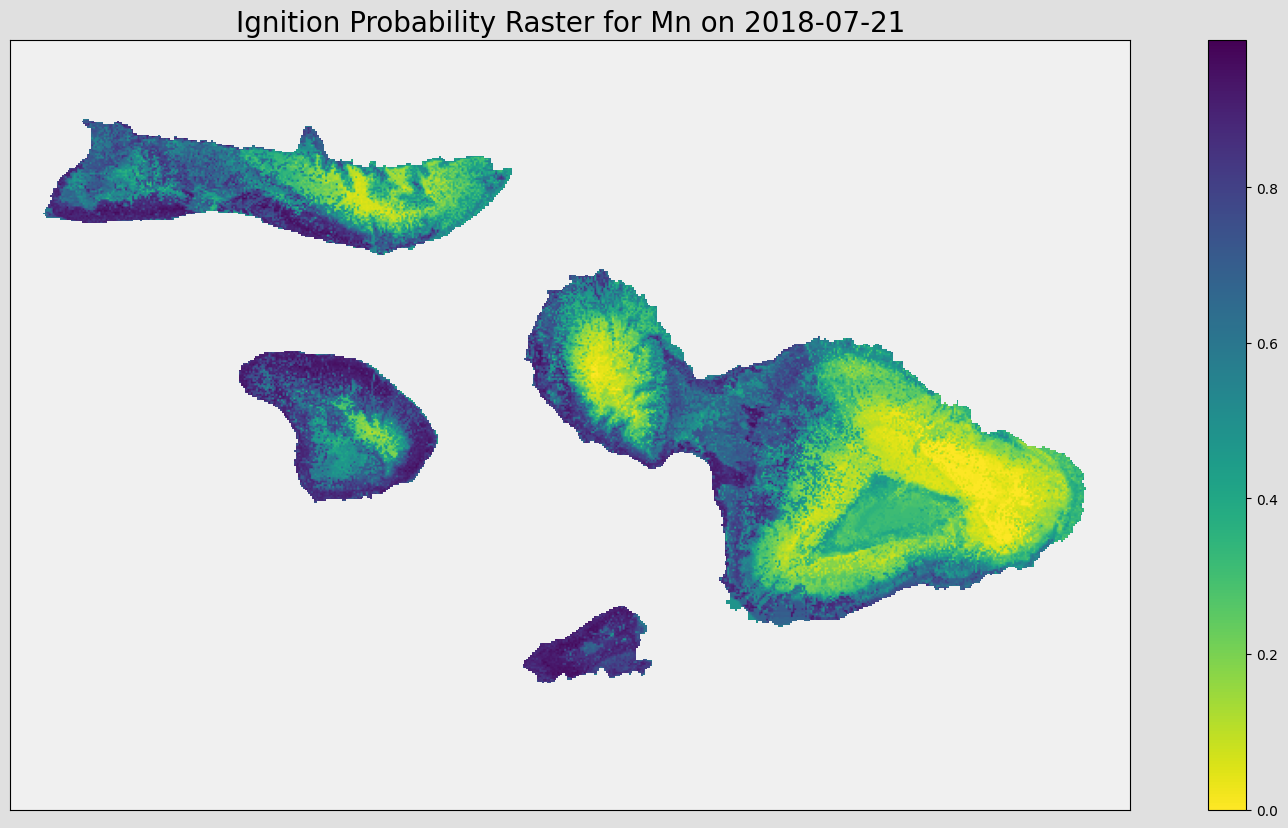

In [13]:
r = await prompt_process_agent.run("Display the ignition probability raster for the Moloka'i in the month of July 21, 2018.")

In [17]:
r = await prompt_process_agent.run("What was the monthly rainfall from August 2020 to August 2022 at the coordinates lat:21.301035061407028,lng:-157.81837141983394? Plot the rainfall timeseries.")    

In [18]:
r.data

'```json\n{"get_rainfall_timeseries_response": "{\\"data_preview\\": [{\\"Date\\": \\"2020-08-01T00:00:00\\", \\"Rainfall (mm)\\": 16.5769}, {\\"Date\\": \\"2020-09-01T00:00:00\\", \\"Rainfall (mm)\\": 13.2603}, {\\"Date\\": \\"2020-10-01T00:00:00\\", \\"Rainfall (mm)\\": 58.6306}, {\\"Date\\": \\"2020-11-01T00:00:00\\", \\"Rainfall (mm)\\": 98.1063}, {\\"Date\\": \\"2020-12-01T00:00:00\\", \\"Rainfall (mm)\\": 77.1709}, {\\"Date\\": \\"2022-04-01T00:00:00\\", \\"Rainfall (mm)\\": 24.1672}, {\\"Date\\": \\"2022-05-01T00:00:00\\", \\"Rainfall (mm)\\": 43.7966}, {\\"Date\\": \\"2022-06-01T00:00:00\\", \\"Rainfall (mm)\\": 15.2876}, {\\"Date\\": \\"2022-07-01T00:00:00\\", \\"Rainfall (mm)\\": 41.099}, {\\"Date\\": \\"2022-08-01T00:00:00\\", \\"Rainfall (mm)\\": 11.9303}], \\"summary\\": {\\"location\\": {\\"lat\\": 21.301035061407028, \\"lng\\": -157.81837141983394}, \\"max\\": 344.201, \\"mean\\": 70.805868, \\"min\\": 11.9303, \\"period\\": \\"2020-08-01 to 2022-08-31\\"}}"}\n```'